In [3]:
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from keras.utils import print_summary
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

# print("hello")

hello


In [29]:
import os 
current_dir = str(os.getcwd())
TRAIN_DIR = current_dir+'/second_dataset/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = current_dir+'/second_dataset/asl_alphabet_test/asl_alphabet_test'
CUSTOM_TEST_DIR = current_dir+'/second_dataset/asl-alphabet-test/asl-alphabet-test'
print("hello")

hello


In [37]:
# # Set global variables
# TRAIN_DIR = './second_dataset/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
# TEST_DIR = './second_dataset/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
# CUSTOM_TEST_DIR = '../input/asl-alphabet-test/asl-alphabet-test'
CLASSES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CLASSES.sort()

TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
N_CLASSES = 29
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

# Model saving for easier local iterations
MODEL_DIR = current_dir+'/second_dataset/'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = getenv('KAGGLE_WORKING_DIR') != '/kaggle/working'

print(MODEL_SAVE_TO_DISK)
# print(os.chdir(TRAIN_DIR))
print(os.listdir())
print(CLASSES)
# print('Save model to disk? {}'.format('Yes' if MODEL_SAVE_TO_DISK else 'No'))

True
['H', 'F', 'Q', 'U', 'G', 'M', 'W', 'J', 'E', 'Y', 'L', 'X', 'K', 'P', 'D', 'S', 'N', 'T', 'nothing', 'O', 'space', 'I', 'R', 'B', 'del', 'Z', 'C', 'V', 'A']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [32]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

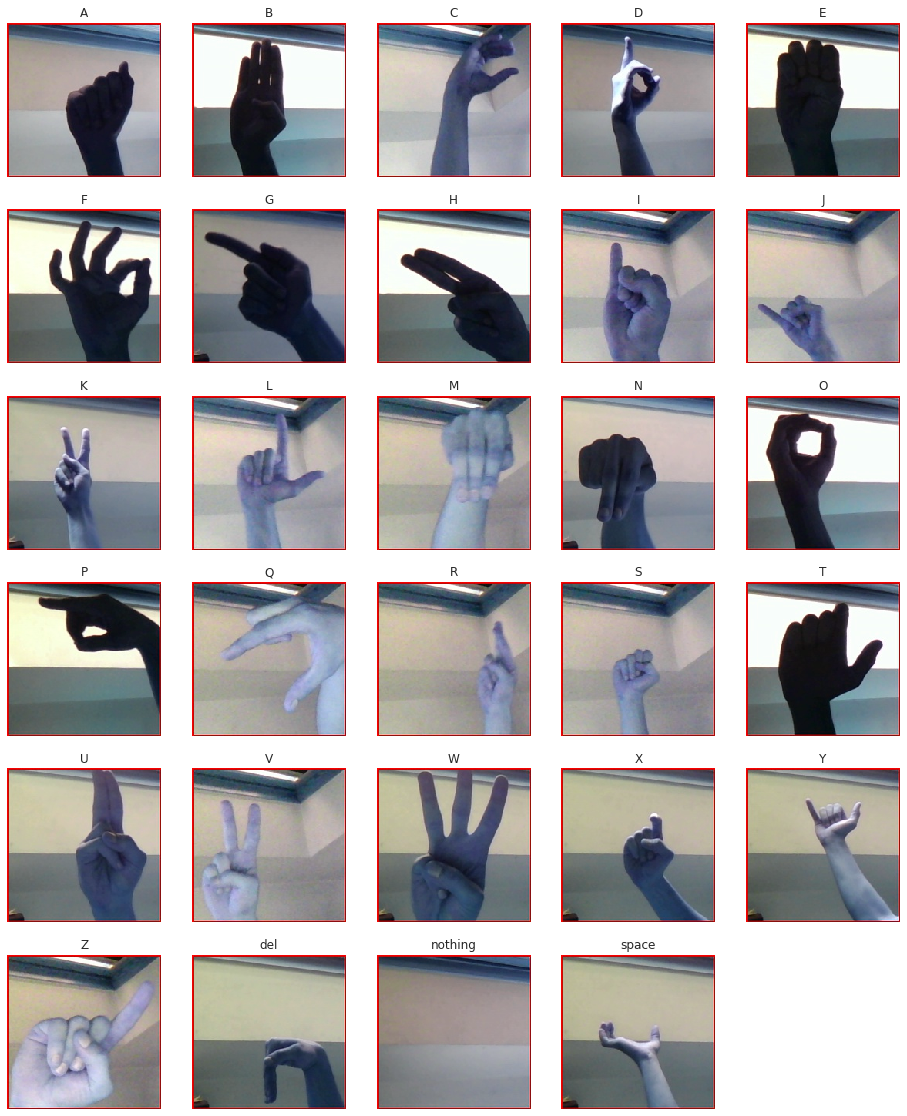

In [33]:
plot_one_sample_of_each(TRAIN_DIR)

In [34]:
plot_one_sample_of_each(CUSTOM_TEST_DIR)

ValueError: Sample larger than population or is negative

<Figure size 1152x1440 with 0 Axes>

In [35]:

def preprocess_image(image):
    '''Function that will be implied on each input. The function
    will run after the image is resized and augmented.
    The function should take one argument: one image (Numpy tensor
    with rank 3), and should output a Numpy tensor with the same
    shape.'''
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return sobely

def make_generator(options):
    '''Creates two generators for dividing and preprocessing data.'''
    validation_split = options.get('validation_split', 0.0)
    preprocessor = options.get('preprocessor', None)
    data_dir = options.get('data_dir', TRAIN_DIR)

    augmentor_options = {
        'samplewise_center': True,
        'samplewise_std_normalization': True,
    }
    if validation_split is not None:
        augmentor_options['validation_split'] = validation_split
    
    if preprocessor is not None:
        augmentor_options['preprocessing_function'] = preprocessor
    
    flow_options = {
        'target_size': TARGET_SIZE,
        'batch_size': BATCH_SIZE,
        'shuffle': options.get('shuffle', None),
        'subset': options.get('subset', None),
    }

    data_augmentor = ImageDataGenerator(**augmentor_options)
    return data_augmentor.flow_from_directory(data_dir, **flow_options)

In [36]:
def load_model_from_disk():
    '''A convenience method for re-running certain parts of the
    analysis locally without refitting all the data.'''
    model_file = Path(MODEL_PATH)
    model_weights_file = Path(MODEL_WEIGHTS_PATH)
                      
    if model_file.is_file() and model_weights_file.is_file():
        print('Retrieving model from disk...')
        model = load_model(model_file.__str__())
                      
        print('Loading CNN model weights from disk...')
        model.load_weights(model_weights_file)
        return model
    
    return None

CNN_MODEL = load_model_from_disk()
REPROCESS_MODEL = (CNN_MODEL is None)

print('Need to reprocess? {}'.format(REPROCESS_MODEL))

Need to reprocess? True


In [38]:
def build_model(save=False):
    print('Building model afresh...')
    
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=TARGET_DIMS))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if save: model.save(MODEL_PATH)
        
    return model

if REPROCESS_MODEL:
    CNN_MODEL = build_model(save=MODEL_SAVE_TO_DISK)

print_summary(CNN_MODEL)


Building model afresh...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           

In [39]:
def make_generator_for(subset):
    '''Create a generator for the training or validation set.'''
    generator_options = dict(
        validation_split=VALIDATION_SPLIT,
        shuffle=True,
        subset=subset,
        preprocessor=preprocess_image,
    )
    return make_generator(generator_options)


def fit_model(model, train_generator, val_generator, save=False):
    '''Fit the model with the training and validation generators.'''    
    history = model.fit_generator(train_generator, epochs=5, validation_data=val_generator)
    
    if save: model.save_weights(MODEL_WEIGHTS_PATH)
    
    return history


CNN_TRAIN_GENERATOR = make_generator_for('training')
CNN_VAL_GENERATOR = make_generator_for('validation')

HISTORY = None
if REPROCESS_MODEL:
    start_time = time.time()
    HISTORY = fit_model(CNN_MODEL, CNN_TRAIN_GENERATOR, CNN_VAL_GENERATOR, save=MODEL_SAVE_TO_DISK)
    print('Fitting the model took ~{:.0f} second(s).'.format(time.time() - start_time))


columns=['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']
pd.DataFrame(data=[x.shape for x in CNN_MODEL.weights], columns=columns)
`

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.

Epoch 1/5
1224/1224 [==============================] - 2314s 2s/step - loss: 1.3075 - accuracy: 0.5880 - val_loss: 0.8377 - val_accuracy: 0.7240
Epoch 2/5
1224/1224 [==============================] - 2218s 2s/step - loss: 0.3189 - accuracy: 0.8921 - val_loss: 1.2085 - val_accuracy: 0.7825
Epoch 3/5
1224/1224 [==============================] - 2294s 2s/step - loss: 0.1999 - accuracy: 0.9337 - val_loss: 0.5837 - val_accuracy: 0.8079
Epoch 4/5
1224/1224 [==============================] - 2277s 2s/step - loss: 0.1667 - accuracy: 0.9461 - val_loss: 1.2490 - val_accuracy: 0.8297
Epoch 5/5
1224/1224 [==============================] - 2320s 2s/step - loss: 0.1482 - accuracy: 0.9538 - val_loss: 0.6156 - val_accuracy: 0.8224
Fitting the model took ~11425 second(s).


,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,4,4,3,64
1,64,None,None,None
2,4,4,64,64
3,64,None,None,None
4,4,4,64,128
5,128,None,None,None
6,4,4,128,128
7,128,None,None,None
8,4,4,128,256
9,256,None,None,None


In [41]:
if HISTORY:
    print('Final Accuracy: {:.2f}%'.format(HISTORY.history['acc'][4] * 100))
    print('Validation set accuracy: {:.2f}%'.format(HISTORY.history['val_acc'][4] * 100))
    

KeyError: 'acc'

In [42]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [43]:
def evaluate_model(generator):
    start_time = time.time()
    evaluations = CNN_MODEL.evaluate_generator(generator)
    for i in range(len(CNN_MODEL.metrics_names)):
        print("{}: {:.2f}%".format(
            CNN_MODEL.metrics_names[i], evaluations[i] * 100))
    print('Took {:.0f} seconds to evaluate this set.'.format(
        time.time() - start_time))

    start_time = time.time()
    predictions = CNN_MODEL.predict_generator(generator)
    print('Took {:.0f} seconds to get predictions on this set.'.format(
        time.time() - start_time))

    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    return dict(y_pred=y_pred, y_true=y_true)


def evaluate_validation_dataset():
    gen_options = dict(
        validation_split=0.1,
        data_dir=TRAIN_DIR,
        shuffle=False,
        subset='validation',
        preprocessor=preprocess_image,
    )
    val_gen = make_generator(gen_options)
    return evaluate_model(val_gen)


def evaluate_test_dataset():
    gen_options = dict(
        validation_split=0.0,
        data_dir=CUSTOM_TEST_DIR,
        shuffle=False,
        preprocessor=preprocess_image,
    )
    test_gen = make_generator(gen_options)
    return evaluate_model(test_gen)

In [44]:
CNN_VALIDATION_SET_EVAL = evaluate_validation_dataset()

Found 8700 images belonging to 29 classes.
loss: 16.87%
accuracy: 82.24%
Took 57 seconds to evaluate this set.
Took 56 seconds to get predictions on this set.


In [45]:
print(classification_report(**CNN_VALIDATION_SET_EVAL, target_names=CLASSES))


              precision    recall  f1-score   support

           A       0.95      0.86      0.90       300
           B       0.91      0.90      0.90       300
           C       1.00      0.92      0.95       300
           D       0.98      0.82      0.89       300
           E       0.65      0.87      0.74       300
           F       1.00      0.86      0.92       300
           G       0.94      0.99      0.96       300
           H       0.99      0.94      0.96       300
           I       0.79      0.94      0.86       300
           J       0.99      1.00      0.99       300
           K       0.97      0.94      0.96       300
           L       0.95      0.92      0.94       300
           M       0.85      0.70      0.76       300
           N       0.72      0.62      0.67       300
           O       0.84      0.80      0.82       300
           P       0.97      1.00      0.99       300
           Q       1.00      0.95      0.97       300
           R       0.67    

Confusion matrix, without normalization


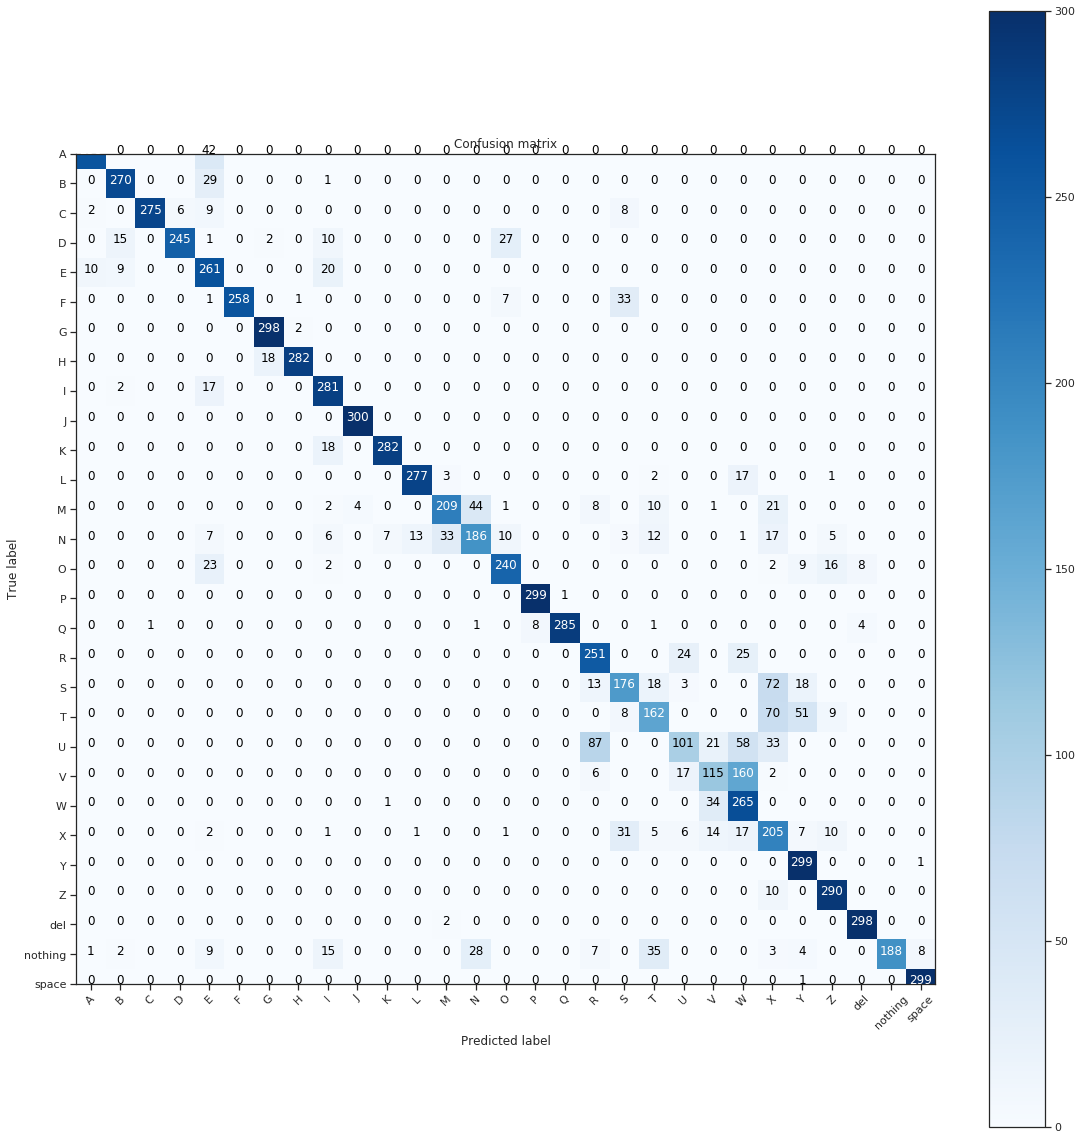

In [46]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_VALIDATION_SET_EVAL, classes=CLASSES)

In [47]:
CNN_TEST_SET_EVAL = evaluate_test_dataset()

FileNotFoundError: [Errno 2] No such file or directory: '/home/shyam/Desktop/MyProjects/HandTalk/second_dataset/asl-alphabet-test/asl-alphabet-test'

In [0]:
print(classification_report(**CNN_TEST_SET_EVAL, target_names=CLASSES))

In [0]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_TEST_SET_EVAL, classes=CLASSES)
    

In [51]:
CNN_MODEL.summary()
CNN_MODEL.save(current_dir+"/second_dataset/handTalk_ver2.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 256)        

(200, 200, 3)


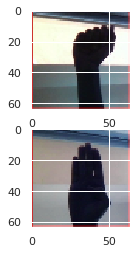

[6]
(1, 64, 64, 3)


In [79]:
a = cv2.imread(current_dir+"/custom/a2.jpg")
b = cv2.imread(current_dir+"/custom/b2.jpg")
# plt.imshow(a)
print(np.shape(a))
new_a = cv2.resize(a,(64,64))
new_b = cv2.resize(b,(64,64))

plt.subplot(2,1,1)
plt.imshow(new_a)
plt.subplot(2,1,2)
plt.imshow(new_b)
plt.show()
# print(new_a)
# print(np.shape(new_a))
new_a = np.reshape(new_a,[1,64,64,3])
new_b = np.reshape(new_b,[1,64,64,3])

x = CNN_MODEL.predict(new_a)
val = max(x[0])
pos = np.where(x[0]==val)
print(pos[0])
print(np.shape(new_a))
# print("for a",CNN_MODEL.predict(new_a))
# print("for b",CNN_MODEL.predict(new_b))